# Task 3: Customer Segmentation / Clustering

To perform clustering, we need to prepare the dataset by combining customer profile information with aggregated transaction data. This dataset will serve as the input for clustering.

In [3]:
import pandas as pd

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')

# Merge datasets
merged_data = pd.merge(transactions, customers, on='CustomerID')
merged_data = pd.merge(merged_data, products, on='ProductID')


In [4]:
# Rename the correct Price column for clarity
merged_data = merged_data.rename(columns={'Price_y': 'Price'})

# Check the updated column names
print(merged_data.columns)


Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price_x', 'CustomerName', 'Region',
       'SignupDate', 'ProductName', 'Category', 'Price'],
      dtype='object')


In [6]:
# Aggregate transactional data for each customer
customer_features = merged_data.groupby('CustomerID').agg({
    'Quantity': 'sum',         # Total quantity purchased
    'TotalValue': 'sum',       # Total spending
    'Price': 'mean'            # Average price of purchased products
}).reset_index()

# Merge back with customer profile data
customer_data = pd.merge(customers, customer_features, on='CustomerID')

# Select relevant features for clustering
clustering_data = customer_data[['Quantity', 'TotalValue', 'Price']]

# Display the prepared dataset
print(clustering_data.head())


   Quantity  TotalValue       Price
0        12     3354.52  278.334000
1        10     1862.74  208.920000
2        14     2725.38  195.707500
3        23     5354.88  240.636250
4         7     2034.24  291.603333


Explanation:
I first merged all three datasets to form a comprehensive dataset with customer profiles and aggregated transaction details. Then, I selected key features (Quantity, TotalValue, Price) for clustering.

## Normalize the Data

To ensure fair clustering, the data is normalized so that all features have equal weight in the clustering process.

In [7]:
from sklearn.preprocessing import StandardScaler

# Normalize the features
scaler = StandardScaler()
normalized_data = scaler.fit_transform(clustering_data)

# Display normalized data
print(normalized_data[:5])


[[-0.12203296 -0.06170143  0.09467022]
 [-0.44800021 -0.87774353 -0.90401592]
 [ 0.20393428 -0.40585722 -1.09410928]
 [ 1.67078689  1.03254704 -0.44770193]
 [-0.93695108 -0.78392861  0.28558127]]


Explanation:
Normalization scales the features to have a mean of 0 and standard deviation of 1. This is critical because clustering algorithms like K-Means are sensitive to feature magnitudes.

## Applying Clustering Algorithm

For clustering, I used the K-Means algorithm. The optimal number of clusters is determined using the Davies-Bouldin Index (DB Index).

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Determine the optimal number of clusters using the DB Index
db_scores = []
for k in range(2, 11):  # Try between 2 and 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    labels = kmeans.labels_
    db_index = davies_bouldin_score(normalized_data, labels)
    db_scores.append((k, db_index))

# Find the optimal number of clusters
optimal_k = min(db_scores, key=lambda x: x[1])[0]
print(f"Optimal number of clusters: {optimal_k}")

# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(normalized_data)


E:\Downloads Disk D\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Downloads Disk D\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Downloads Disk D\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Downloads Disk D\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL

Optimal number of clusters: 9


E:\Downloads Disk D\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Downloads Disk D\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Explanation:
I used K-Means as the clustering algorithm and evaluated the clustering quality for different numbers of clusters using the Davies-Bouldin Index. The optimal number of clusters corresponds to the lowest DB Index value.

Clusters were visualized using a 2D scatter plot. To reduce the dimensionality of the data, PCA was applied.

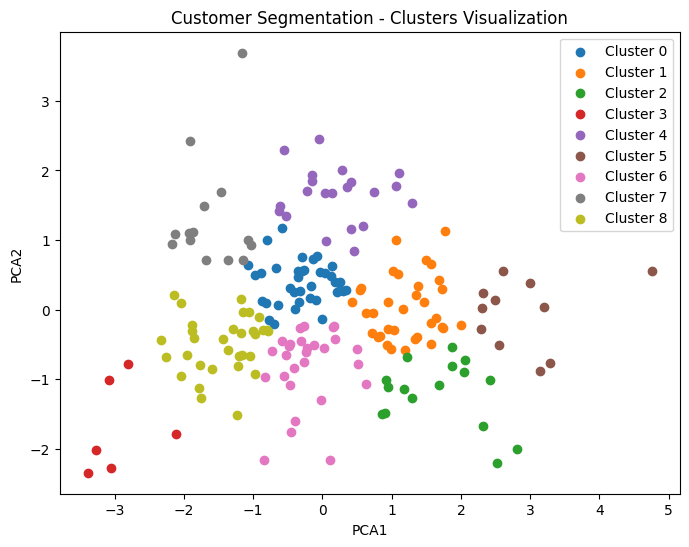

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_data)
customer_data['PCA1'] = reduced_data[:, 0]
customer_data['PCA2'] = reduced_data[:, 1]

# Plot the clusters
plt.figure(figsize=(8, 6))
for cluster in range(optimal_k):
    cluster_data = customer_data[customer_data['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')

plt.title('Customer Segmentation - Clusters Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()


Explanation:
I reduced the dimensions of the dataset to 2 using PCA for visualization purposes. Each cluster is plotted with a unique color to show how customers are segmented.

## Evaluating Clustering Metrics

Apart from the DB Index, additional clustering metrics such as inertia (sum of squared distances to the nearest cluster center) were calculated.

In [10]:
# Calculate inertia
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

# Calculate DB Index for the final clustering
final_db_index = davies_bouldin_score(normalized_data, customer_data['Cluster'])
print(f"Davies-Bouldin Index: {final_db_index}")


Inertia: 90.84555008099365
Davies-Bouldin Index: 0.8569538613614833


Explanation:
Inertia gives a measure of how compact the clusters are, while the Davies-Bouldin Index evaluates cluster separation. These metrics help assess the quality of clustering.

In [12]:
# Save clustering results to a CSV file
customer_data[['CustomerID', 'Cluster']].to_csv('Doradla_PardhaSaradhiRaju_Clustering.csv', index=False)
print("Clustering results saved successfully.")


Clustering results saved successfully.


Explanation:
The final dataset, including CustomerID and their respective cluster labels, was saved to a CSV file for submission.